<a href="https://colab.research.google.com/github/rkeaveney/ped-detect-predict/blob/main/lstm_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Initialising

In [ ]:
import os
import sys
import math
import cv2
import numpy as np
import pandas as pd
import random
import shutil
import matplotlib.pyplot as plt
import copy
from PIL import Image
import io
import glob
import pickle
import imageio
from ipywidgets import widgets, Layout, HBox
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from datetime import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!tar -xzf /content/drive/MyDrive/UL/EE6061/data/all_data.tar.gz

^C


### Training

In [ ]:
lstm_labels = [os.path.join("lstm_labels", x) for x in sorted(os.listdir("lstm_labels"))]
random.shuffle(lstm_labels)
train_lstm_labels = lstm_labels[:1200]
test_lstm_labels = lstm_labels[1200:]

In [ ]:
# load the model
model = VGG16()
    
# re-structure the model
model = Model(inputs=model.inputs, outputs=model.layers[-5].output)
    
# summarize
print(model.summary())
    
# extract features from each photo
features = dict()

current = 0

lstm_images = [os.path.join("lstm", x) for x in sorted(os.listdir("lstm"))]

total = len(lstm_images)

for filename in lstm_images:
    print(current, '/', total)

    # load the image and convert it into target size of 224*224
    image = load_img(filename, target_size=(224, 224))
        
    # convert the image pixels to a numpy array
    image = img_to_array(image)
        
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        
    # prepare the image for the VGG model
    image = preprocess_input(image)
    
    # get features
    feature = model.predict(image, verbose=0)
    
    # get image id
    image_id = filename.replace('lstm/', '').replace('.jpg', '')
    
    # store feature
    features[image_id] = np.squeeze(feature)

    current += 1

Streaming output truncated to the last 5000 lines.
27040 / 32040
27041 / 32040
27042 / 32040
27043 / 32040
27044 / 32040
27045 / 32040
27046 / 32040
27047 / 32040
27048 / 32040
27049 / 32040
27050 / 32040
27051 / 32040
27052 / 32040
27053 / 32040
27054 / 32040
27055 / 32040
27056 / 32040
27057 / 32040
27058 / 32040
27059 / 32040
27060 / 32040
27061 / 32040
27062 / 32040
27063 / 32040
27064 / 32040
27065 / 32040
27066 / 32040
27067 / 32040
27068 / 32040
27069 / 32040
27070 / 32040
27071 / 32040
27072 / 32040
27073 / 32040
27074 / 32040
27075 / 32040
27076 / 32040
27077 / 32040
27078 / 32040
27079 / 32040
27080 / 32040
27081 / 32040
27082 / 32040
27083 / 32040
27084 / 32040
27085 / 32040
27086 / 32040
27087 / 32040
27088 / 32040
27089 / 32040
27090 / 32040
27091 / 32040
27092 / 32040
27093 / 32040
27094 / 32040
27095 / 32040
27096 / 32040
27097 / 32040
27098 / 32040
27099 / 32040
27100 / 32040
27101 / 32040
27102 / 32040
27103 / 32040
27104 / 32040
27105 / 32040
27106 / 32040
27107 / 320

In [ ]:
train_bbox = []

for label in sorted(train_lstm_labels):
    uid = label.replace('lstm_labels/', '').replace('.txt', '')
    bboxes = []
    with open(label) as label_file:
        rows = label_file.readlines()
        for row in rows:
            left, top, right, bottom = row.split()
            bbox = float(left), float(top), float(right), float(bottom)
            bboxes.append(bbox)
    train_bbox.append(bboxes)

In [ ]:
train_feat = []

for label in sorted(train_lstm_labels):
    feats = []
    uid = label.replace('lstm_labels/', '').replace('.txt', '')
    im_ids = [s.replace('lstm/', '').replace('.jpg', '') for s in lstm_images if uid in s]
    for im_id in im_ids:
        feats.append(features[im_id])
    train_feat.append(feats)

In [ ]:
def X_frames(data, n_frames):
    output = []
    for i in range(len(data)):
        output.append(data[i][:n_frames][:][:])
    return output

def Y_frames(data, n_frames):
    output = []
    for i in range(len(data)):
        output.append(data[i][n_frames:][:][:])
    return output

train_X_feat = np.array(X_frames(train_feat, 10))
train_X_bbox = np.array(X_frames(train_bbox, 10))
train_Y_feat = np.array(Y_frames(train_feat, 10))
train_Y_bbox = np.array(Y_frames(train_bbox, 10))

In [ ]:
"""with open('train_X_feat.pickle', 'wb') as f:
    pickle.dump(train_X_feat, f)
with open('train_X_bbox.pickle', 'wb') as f:
    pickle.dump(train_X_bbox, f)
with open('train_Y_feat.pickle', 'wb') as f:
    pickle.dump(train_Y_feat, f)
with open('train_Y_bbox.pickle', 'wb') as f:
    pickle.dump(train_Y_bbox, f)

!cp *.pickle /content/drive/MyDrive/UL/EE6061/pickles"""

In [ ]:
print(train_X_feat.shape)
print(train_Y_bbox.shape)

(1200, 10, 7, 7, 512)
(1200, 10, 4)


In [ ]:
input_feat = layers.Input(shape=(10,7,7,512))
input_bbox = tf.keras.layers.Input(shape=(10, 4))
n_past = 10
n_future = 10

In [ ]:
model_feat = layers.ConvLSTM2D(
                               filters=64,
                               kernel_size=(2, 2),             # dimensions of conv window
                               padding="valid",                # no padding
                               return_sequences=False,
                               activation="relu",              # relu(x) = max(x, 0)
                               )(input_feat)
model_feat = tf.keras.layers.Flatten()(model_feat)
model_feat = tf.keras.layers.RepeatVector(n_past)(model_feat)
model_feat = tf.keras.layers.Concatenate()([model_feat, input_bbox])
model_feat = tf.keras.layers.LSTM(128, return_state=False)(model_feat)
model_feat = tf.keras.layers.RepeatVector(n_future)(model_feat)

In [ ]:
attention = tf.keras.layers.Permute((2, 1), input_shape=(n_past, 4))(input_bbox)
attention = tf.keras.layers.Dense(n_past, activation='relu')(attention)
attention = tf.keras.layers.Permute((2, 1), input_shape=(4,n_past))(attention)
attention = tf.keras.layers.Multiply()([attention,input_bbox])
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(attention)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(4))(decoder_l1)

In [ ]:
decoder = tf.keras.layers.Concatenate()([model_feat, decoder_l1])
decoder = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(4))(decoder)

In [ ]:
model_conv = keras.models.Model([input_feat,input_bbox], decoder)
model_conv.compile(
    loss=keras.losses.Huber(), optimizer=keras.optimizers.Adam(),
)

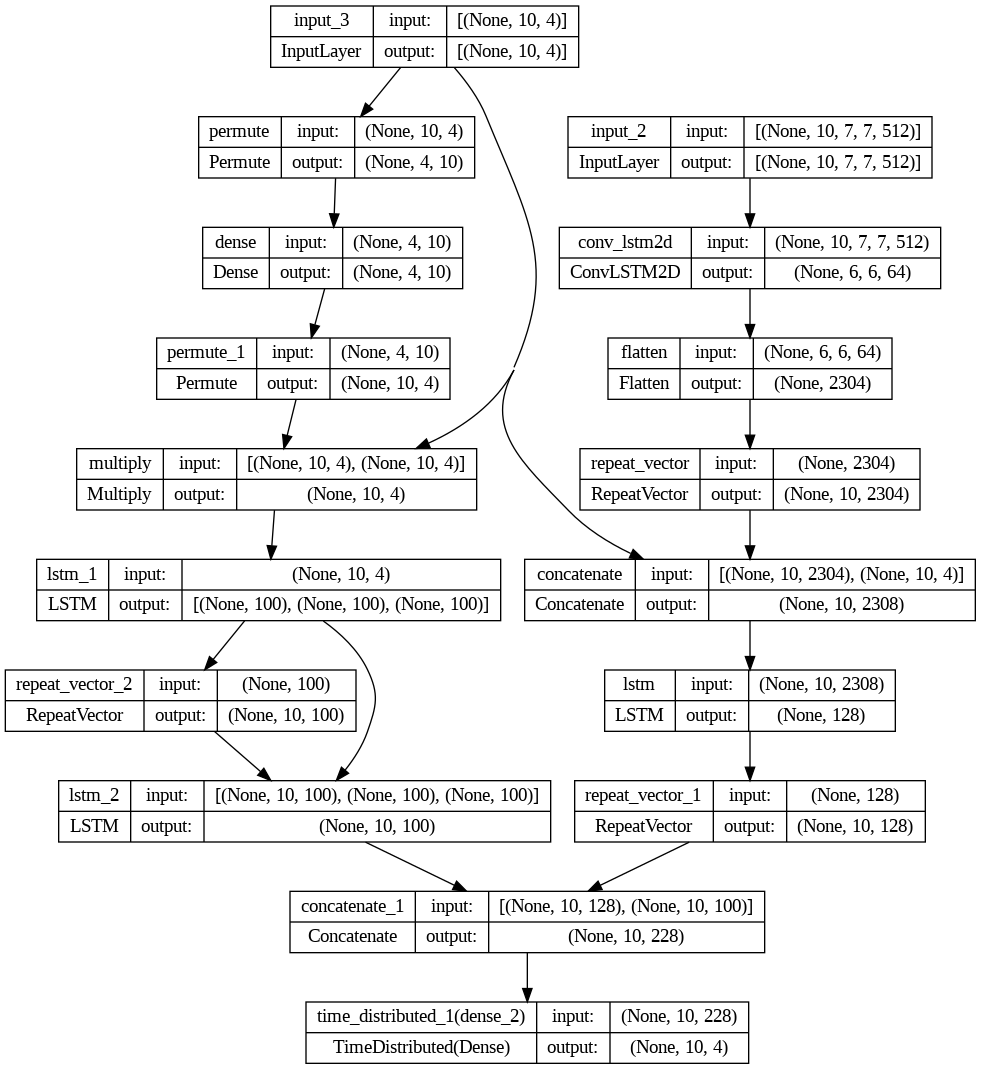

In [ ]:
plot_model(model_conv,show_shapes=True)

In [ ]:
model_conv.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10, 4)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10, 7, 7, 5  0           []                               
                                12)]                                                              
                                                                                                  
 permute (Permute)              (None, 4, 10)        0           ['input_3[0][0]']                
                                                                                                  
 conv_lstm2d (ConvLSTM2D)       (None, 6, 6, 64)     590080      ['input_2[0][0]']          

In [ ]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)

In [ ]:
model_conv.fit([train_X_feat, train_X_bbox], train_Y_bbox, epochs=100, batch_size=8, verbose=1, callbacks=[reduce_lr])

Epoch 1/100
150/150 [==============================] - 14s 30ms/step - loss: 0.0184 - lr: 0.0010
Epoch 2/100
150/150 [==============================] - 5s 30ms/step - loss: 0.0023 - lr: 9.0000e-04
Epoch 3/100
150/150 [==============================] - 5s 31ms/step - loss: 0.0017 - lr: 8.1000e-04
Epoch 4/100
150/150 [==============================] - 5s 30ms/step - loss: 0.0014 - lr: 7.2900e-04
Epoch 5/100
150/150 [==============================] - 5s 31ms/step - loss: 0.0016 - lr: 6.5610e-04
Epoch 6/100
150/150 [==============================] - 5s 31ms/step - loss: 0.0011 - lr: 5.9049e-04
Epoch 7/100
150/150 [==============================] - 5s 30ms/step - loss: 0.0014 - lr: 5.3144e-04
Epoch 8/100
150/150 [==============================] - 5s 31ms/step - loss: 5.6286e-04 - lr: 4.7830e-04
Epoch 9/100
150/150 [==============================] - 5s 30ms/step - loss: 3.7762e-04 - lr: 4.3047e-04
Epoch 10/100
150/150 [==============================] - 5s 30ms/step - loss: 3.7028e-04 - lr: 3

In [ ]:
now = datetime.now()
model_file = 'ConvLSTM_model_' + now.strftime("%Y-%m-%d_%H:%M") + '.h5'
model_conv.save(model_file)

### Testing


In [ ]:
test_bbox = []

for label in sorted(test_lstm_labels):
    uid = label.replace('lstm_labels/', '').replace('.txt', '')
    bboxes = []
    with open(label) as label_file:
        rows = label_file.readlines()
        for row in rows:
            left, top, right, bottom = row.split()
            bbox = float(left), float(top), float(right), float(bottom)
            bboxes.append(bbox)
    test_bbox.append(bboxes)

test_bbox = np.array(test_bbox)

In [ ]:
test_X_bbox = np.array(X_frames(test_bbox, 10))
test_Y_bbox = np.array(Y_frames(test_bbox, 10))

In [ ]:
test_feat = []

for label in sorted(test_lstm_labels):
    feats = []
    uid = label.replace('lstm_labels/', '').replace('.txt', '')
    im_ids = [s.replace('lstm/', '').replace('.jpg', '') for s in lstm_images if uid in s]
    for im_id in im_ids:
        feats.append(features[im_id])
    test_feat.append(feats)

In [ ]:
test_X_feat = np.array(X_frames(test_feat, 10))

In [ ]:
pred_Y_bbox = model_conv.predict([test_X_feat, test_X_bbox])

13/13 [==============================] - 2s 21ms/step


In [ ]:
pred_Y_centre = []
for ped in range(len(pred_Y_bbox)):
    ped_centre = []
    for frame in range(len(pred_Y_bbox[ped])):
        xy = []
        xy.append(int((pred_Y_bbox[ped][frame][2] + pred_Y_bbox[ped][frame][0])*960))
        xy.append(int((pred_Y_bbox[ped][frame][3] + pred_Y_bbox[ped][frame][1])*960))
        ped_centre.append(xy)
    pred_Y_centre.append(ped_centre)

test_Y_centre = []
for ped in range(len(test_Y_bbox)):
    ped_centre = []
    for frame in range(len(test_Y_bbox[ped])):
        xy = []
        xy.append(int((test_Y_bbox[ped][frame][2] + test_Y_bbox[ped][frame][0])*960))
        xy.append(int((test_Y_bbox[ped][frame][3] + test_Y_bbox[ped][frame][1])*960))
        ped_centre.append(xy)
    test_Y_centre.append(ped_centre)

In [ ]:
line_Y_centre = []
for ped in range(len(line_Y_bbox)):
    ped_centre = []
    for frame in range(len(line_Y_bbox[ped])):
        xy = []
        xy.append(int((line_Y_bbox[ped][frame][2] + line_Y_bbox[ped][frame][0])*960))
        xy.append(int((line_Y_bbox[ped][frame][3] + line_Y_bbox[ped][frame][1])*960))
        ped_centre.append(xy)
    line_Y_centre.append(ped_centre)

In [ ]:
from math import sqrt as sqrt

In [ ]:
dis_error = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
x_error = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
y_error = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
x = []
for frame in range(10):
    count = 0
    for i in range(402):
        x_t, y_t = test_Y_centre[i][frame]
        x_p, y_p = pred_Y_centre[i][frame]
        de = sqrt((x_t - x_p)**2 + (y_t - y_p)**2)
        if frame == 9 and de < 10:
            x.append(i)
            dis_error[frame] += de
            count += 1
        #x_error[frame] += abs(x_t - x_p)
        #y_error[frame] += abs(y_t - y_p)
    dis_error[frame] /= 1
    #x_error[frame] /= 402
    #y_error[frame] /= 402
    print(x)

[]
[]
[]
[]
[]
[]
[]
[]
[]
[7, 11, 15, 40, 50, 63, 64, 74, 78, 86, 87, 88, 89, 97, 98, 103, 127, 128, 134, 147, 154, 161, 165, 180, 183, 186, 191, 195, 211, 240, 271, 280, 291, 295, 296, 305, 309, 312, 325, 335, 342, 348, 352, 357, 364, 381, 386, 388, 398]


In [ ]:
y_MSE = np.mean((pred_Y_bbox[:]-test_Y_bbox[:])**2)
print(y_MSE)
y_MSE = np.mean((line_Y_bbox[:]-test_Y_bbox[:])**2)
print(y_MSE)

0.00028731389320609506
0.0004526570826685656


In [ ]:
"""with open('test_lstm_labels.pickle', 'wb') as f:
    pickle.dump(sorted(test_lstm_labels), f)
with open('pred_Y_bbox.pickle', 'wb') as f:
    pickle.dump(pred_Y_bbox, f)
with open('test_Y_bbox.pickle', 'wb') as f:
    pickle.dump(test_Y_bbox, f)
with open('test_X_bbox.pickle', 'wb') as f:
    pickle.dump(test_X_bbox, f)"""

In [ ]:
#!cp test_X_bbox.pickle test_lstm_labels.pickle pred_Y_bbox.pickle test_Y_bbox.pickle /content/drive/MyDrive/UL/EE6061/pickles

In [ ]:
#!cp /content/drive/MyDrive/UL/EE6061/pickles/test_lstm_labels.pickle \
#    /content/drive/MyDrive/UL/EE6061/pickles/pred_Y_bbox.pickle      \
#    /content/drive/MyDrive/UL/EE6061/pickles/test_X_bbox.pickle      \
#    /content/drive/MyDrive/UL/EE6061/pickles/test_Y_bbox.pickle .

In [ ]:
"""with open('test_lstm_labels.pickle', 'rb') as f:
    test_lstm_labels = pickle.load(f)
with open('pred_Y_bbox.pickle', 'rb') as f:
    pred_Y_bbox = pickle.load(f)
with open('test_Y_bbox.pickle', 'rb') as f:
    test_Y_bbox = pickle.load(f)
with open('test_X_bbox.pickle', 'rb') as f:
    test_X_bbox = pickle.load(f)"""

### Linear Regression Model

In [ ]:
line_Y_bbox = [[[0 for k in range(4)] for j in range(10)] for i in range(402)]
for ped in range(len(test_X_bbox)):
    for coord in range(4):
        diff = 0
        for fr in range(1, 10):
            diff += test_X_bbox[ped][fr][coord] - test_X_bbox[ped][fr - 1][coord]
        diff /= 9
        line_Y_bbox[ped][0][coord] = test_X_bbox[ped][9][coord] + diff
        for fr in range(1, 10):
            line_Y_bbox[ped][fr][coord] = line_Y_bbox[ped][fr - 1][coord] + diff